# <div style='background:darkblue'>  <font color='white'>  <b>&nbsp;Importing Libraries</b> </font> </div>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
from tabulate import tabulate
import random
import tensorflow as tf
import os
import kagglehub

# <div style='background:darkblue'>  <font color='white'>  <b>&nbsp;Read input file from Kaggle</b> </font> </div>

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
dataset_path = kagglehub.dataset_download('jainilcoder/online-payment-fraud-detection')
print("Data downloaded to:", dataset_path)
csv_file = os.path.join(dataset_path, "onlinefraud.csv")

Data downloaded to: /Users/usamasaleem/.cache/kagglehub/datasets/jainilcoder/online-payment-fraud-detection/versions/1


# <div style='background:darkblue'>  <font color='white'>  <b>&nbsp;Introduction</b> </font> </div>


In [9]:
df = pd.read_csv(csv_file)
df.drop('isFlaggedFraud', axis=1, inplace=True)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


Online payment is the most popular transaction method in the world today. However, with an increase in online payments also comes a rise in payment fraud. The objective of this study is **to identify fraudulent and non-fraudulent payments**. The dataset is collected from Kaggle, which contains historical information about fraudulent transactions which can be used to detect fraud in online payments.


The dataset consists of 10 variables:
* **step**: represents a unit of time where 1 step equals 1 hour
* **type**: type of online transaction
* **amount**: the amount of the transaction
* **nameOrig**: customer starting the transaction
* **oldbalanceOrg**: balance before the transaction
* **newbalanceOrig**: balance after the transaction
* **nameDest**: recipient of the transaction
* **oldbalanceDest**: initial balance of recipient before the transaction
* **newbalanceDest**: the new balance of recipient after the transaction
* **isFraud**: fraud transaction

# <div style='background:darkblue'>  <font color='white'> <b>&nbsp;Exploratory Data Analysis</b></font> </div>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


* The dataset consists of 6,362,620 observations.

In [ ]:
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
4359309,309,CASH_OUT,233780.54,C881784495,91553.00,0.00,C530333327,417966.25,651746.79,0
5871488,403,CASH_IN,123934.19,C1401595992,395870.29,519804.47,C720173315,7797113.66,7673179.48,0
5220466,370,PAYMENT,26261.41,C1747848824,0.00,0.00,M1897506539,0.00,0.00,0
3713201,277,TRANSFER,586931.70,C1917470190,20029.00,0.00,C1831837643,140.00,529988.86,0
3871335,283,CASH_OUT,41190.54,C1626990108,0.00,0.00,C192467981,79789.94,120980.48,0


In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


* There are no missing values.

In [ ]:
fraud_min_max = [
    ['amount', df.amount.min(), df.amount.max()],
    ['oldbalanceOrg', df.oldbalanceOrg.min(), df.oldbalanceOrg.max()],
    ['newbalanceOrig', df.newbalanceOrig.min(), df.newbalanceOrig.max()],
    ['oldbalanceDest', df.oldbalanceDest.min(), df.oldbalanceDest.max()],
    ['isFraud', df.isFraud.min(), df.isFraud.max()]
]

print(
    tabulate(
        fraud_min_max,
        headers=['columns', 'min value', 'max value'],
        showindex=True,
        tablefmt='github',
        numalign='right'
    )
)

|    | columns        |   min value |   max value |
|----|----------------|-------------|-------------|
|  0 | amount         |           0 | 9.24455e+07 |
|  1 | oldbalanceOrg  |           0 |  5.9585e+07 |
|  2 | newbalanceOrig |           0 |  4.9585e+07 |
|  3 | oldbalanceDest |           0 | 3.56016e+08 |
|  4 | isFraud        |           0 |           1 |


In [ ]:
# Downcast numerical columns with smaller dtype
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col] = pd.to_numeric(df[col], downcast='float')
    if df[col].dtype == 'int64':
        df[col] = pd.to_numeric(df[col], downcast='unsigned')

# Use category dtype for categorical column
df['type'] = df['type'].astype('category')

In [ ]:
# Check duplicate values
df.duplicated().sum()

np.int64(0)

* There are no duplicate values.

In [ ]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8,6)

<h2>
    <div style='background:steelblue'>
    <font color='white'>
    <b>&nbsp; Univariate data visualization</b>
    </font>
    </div>
</h2>

In [ ]:
df['step'].value_counts()

,count
step,
19,51352
18,49579
187,49083
235,47491
307,46968
...,...
706,4
721,4
693,4


* There are **743** steps, and every step has **at least 2** occurrences.

<ipython-input-14-c316b7b7b898>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='type', data=df, palette='PuBu')
<ipython-input-14-c316b7b7b898>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')


Text(0, 0.5, 'Number of transactions')

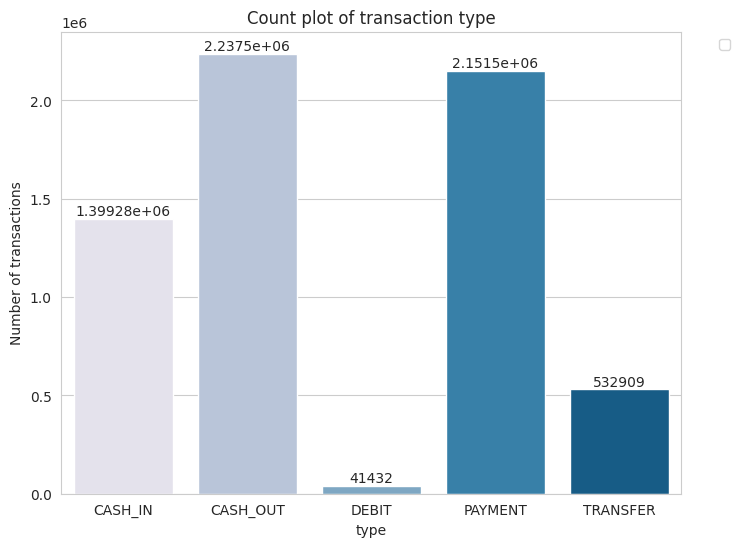

In [ ]:
ax = sns.countplot(x='type', data=df, palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of transaction type')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')

* **Cash out** is **the most numerous** transaction type, followed by payment, cash in, transfer and debit types.

Text(0.5, 1.0, 'Distribution of transaction amount')

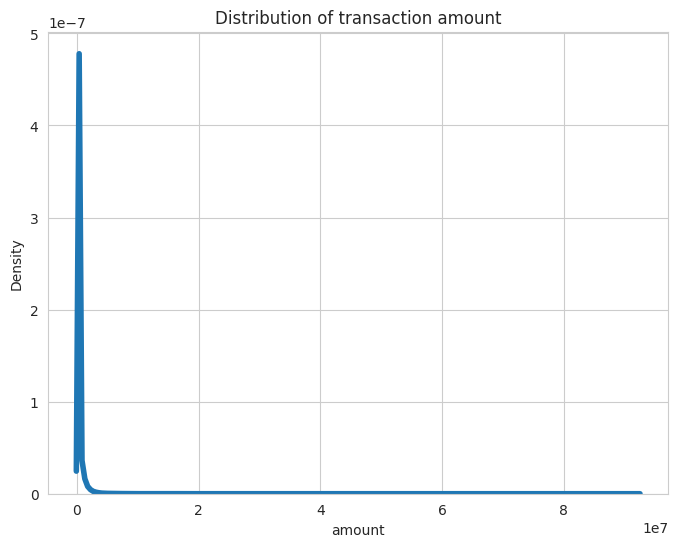

In [ ]:
sns.kdeplot(df['amount'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of transaction amounts is **right skewed**.
* This indicates that most values are clustered around the left tail of the distribution, with the longer right tail.
* (mode < median < mean)

In [ ]:
df['nameOrig'].value_counts()

,count
nameOrig,
C1530544995,3
C545315117,3
C724452879,3
C1784010646,3
C1677795071,3
...,...
C1567523029,1
C644777639,1
C1256645416,1


* There are **6353307** initial customers, and every step has **at least 1** occurrence.

Text(0.5, 1.0, 'Distribution of transaction amount')

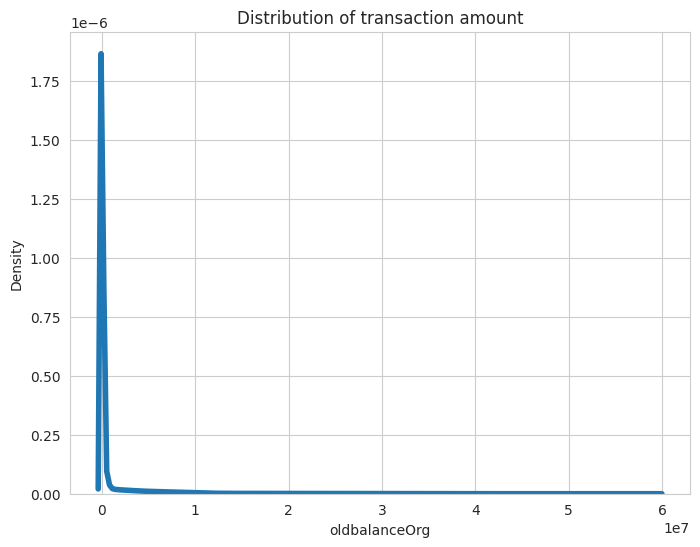

In [ ]:
sns.kdeplot(df['oldbalanceOrg'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of pre-transaction balances of the initial customers is **right skewed**.

Text(0.5, 1.0, 'Distribution of transaction amount')

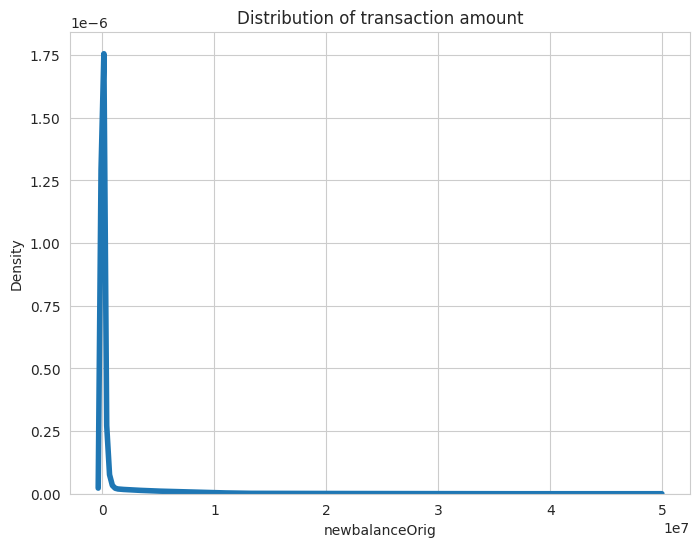

In [ ]:
sns.kdeplot(df['newbalanceOrig'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of post-transaction balances of the initial customers is **right skewed**.

In [ ]:
df['nameDest'].value_counts()

,count
nameDest,
C1286084959,113
C985934102,109
C665576141,105
C2083562754,102
C248609774,101
...,...
M367627425,1
M1902904124,1
M242332837,1


* There are **2722362** recipients, and every step has **at least 1** occurrence.

Text(0.5, 1.0, 'Distribution of transaction amount')

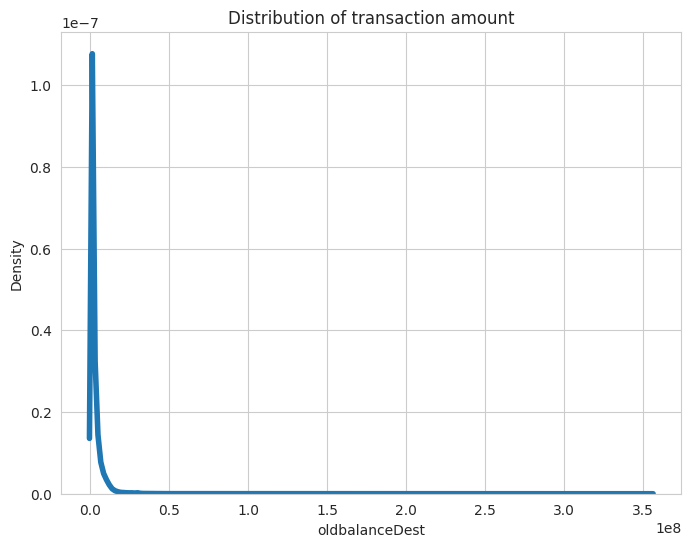

In [ ]:
sns.kdeplot(df['oldbalanceDest'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of pre-transaction balances of the recipient is **right skewed**.

Text(0.5, 1.0, 'Distribution of transaction amount')

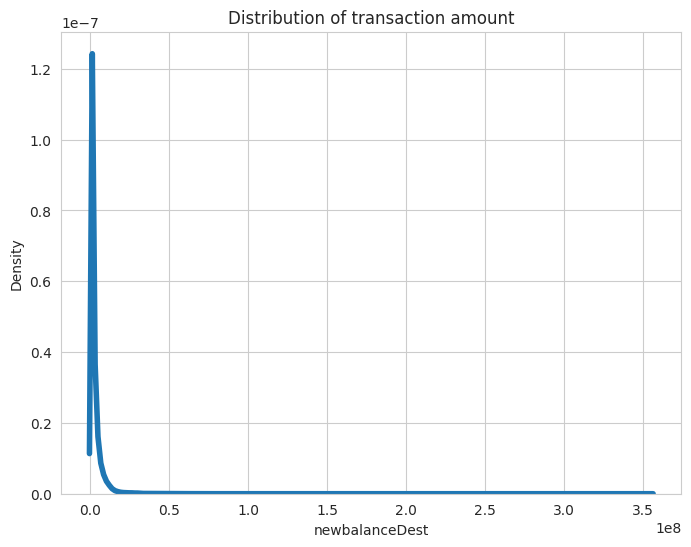

In [ ]:
sns.kdeplot(df['newbalanceDest'], linewidth=4)
plt.title('Distribution of transaction amount')

* The distribution of post-transaction balances of the recipient is **right skewed**.

<ipython-input-22-d174391ea540>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='isFraud', data=df, palette='PuBu')


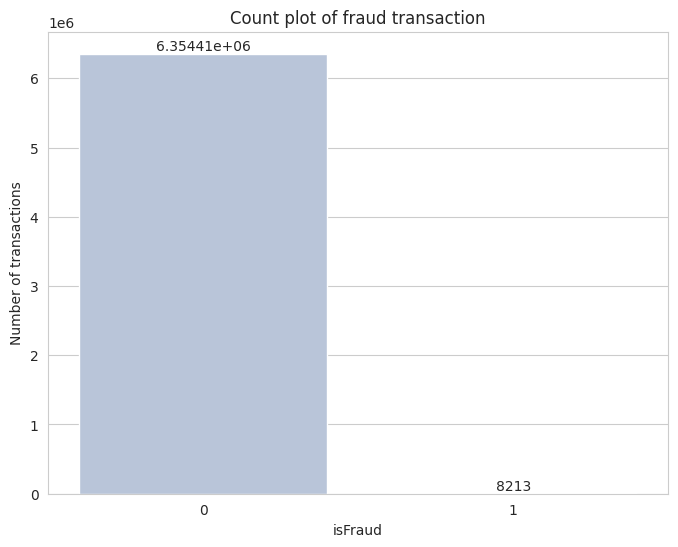

In [ ]:
ax = sns.countplot(x='isFraud', data=df, palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of fraud transaction')
plt.ylabel('Number of transactions')

del ax

* There are much **more non-fraudulent transactions** than fraudulent transactions.

<h2>
    <div style='background:steelblue'>
    <font color='white'>
    <b>&nbsp; Bivariate data visualization</b>
    </font>
    </div>
</h2>

<ipython-input-23-6c0ccffb48ce>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2 = df.groupby(['type', 'isFraud']).size().unstack()


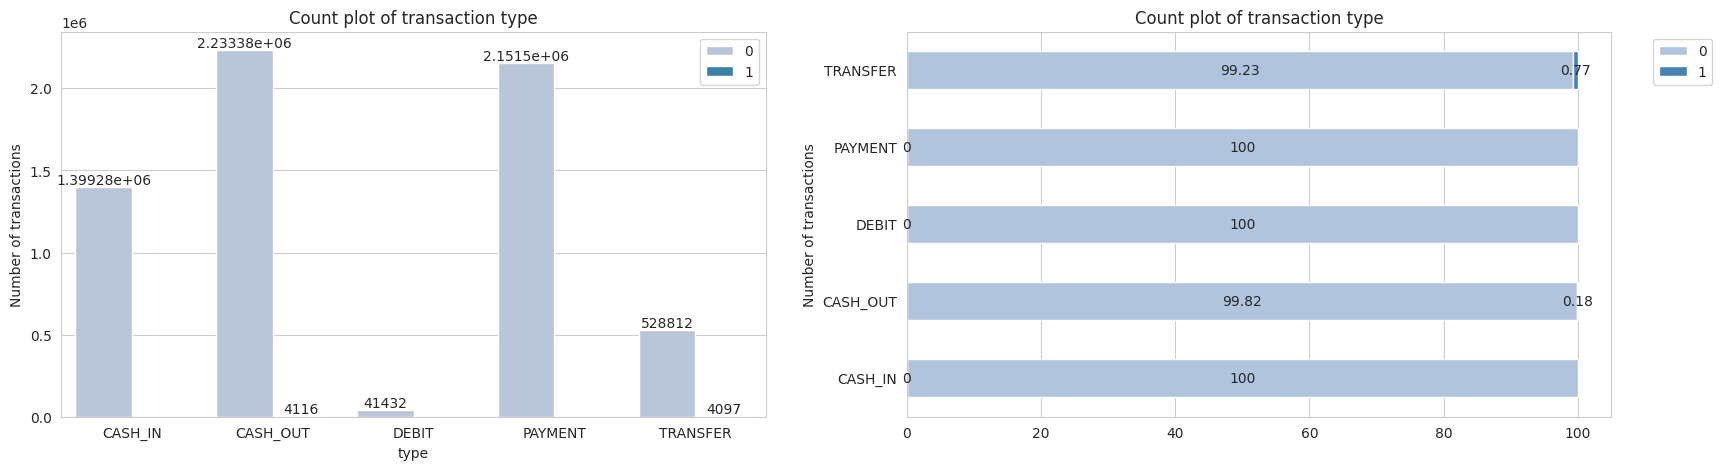

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.countplot(x='type', data=df, hue='isFraud', palette='PuBu', ax=ax[0])
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[0].set_title('Count plot of transaction type')
ax[0].legend(loc='best')
ax[0].set_ylabel('Number of transactions')

df2 = df.groupby(['type', 'isFraud']).size().unstack()
df2.apply(lambda x : round(x/sum(x)*100, 2), axis=1).plot(kind='barh', stacked=True, color=['lightsteelblue', 'steelblue'], ax=ax[1])
for container in ax[1].containers:
    ax[1].bar_label(container, label_type='center')
ax[1].set_title('Count plot of transaction type')
ax[1].legend(bbox_to_anchor=(1.05,1), loc='upper left')
ax[1].set_ylabel('Number of transactions')
ax[1].grid(axis='y')

* Fraudulent transactions only occur in debit and transfer types.

Text(0, 0.5, 'Number of transactions')

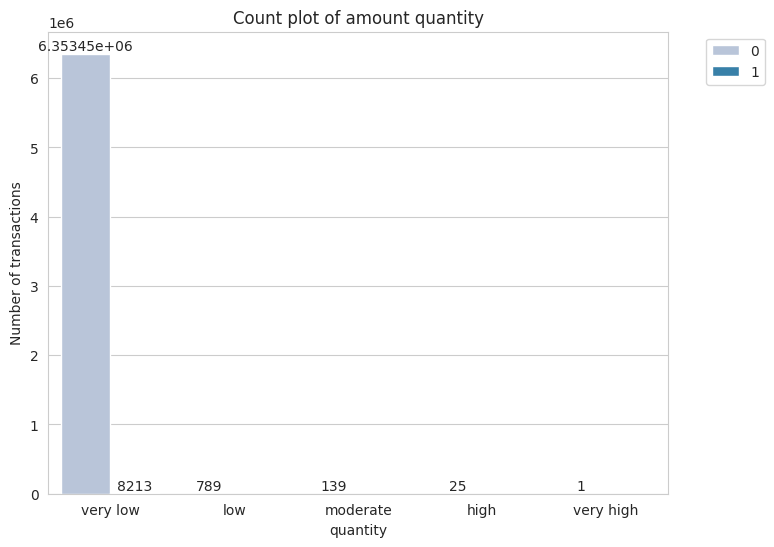

In [ ]:
df['quantity'] = pd.cut(df['amount'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='quantity', data=df, hue='isFraud', palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of amount quantity')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')

* All fraudulent transactions fall into the category of very low amounts.
* This suggests that in most cases, small transactions are more prone to fraudulent transactions.

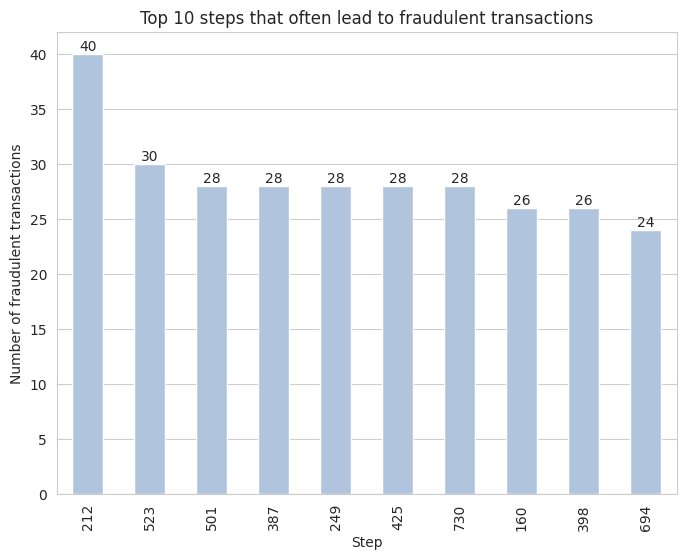

In [ ]:
df1 = df[df['isFraud']==1]
df2 = df1['step'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 steps that often lead to fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Step')
plt.grid(axis='x')

del ax, df2

* **Step 212** has the highest number of fraudulent transactions, 40 cases.
* This indicates that Step 212 is the step that will most likely lead to fraudulent transactions.

Text(0.5, 0, 'Initial customers pre-transaction balance amount')

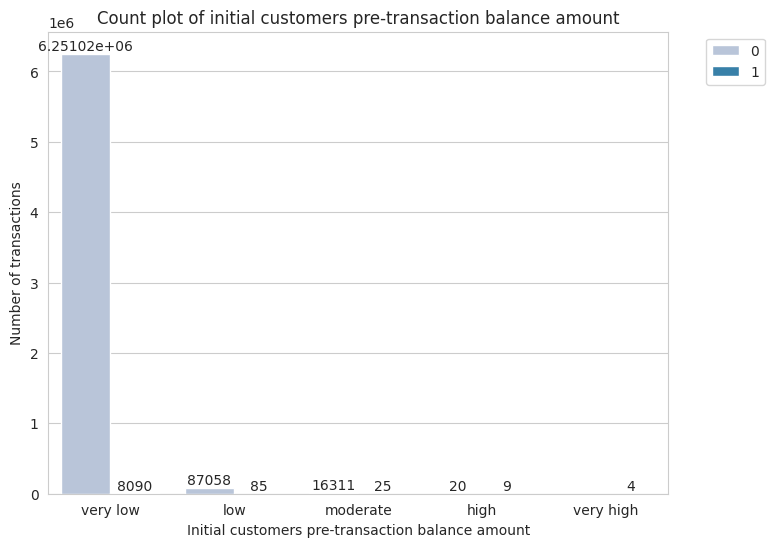

In [ ]:
df['oldbalanceOrg_amt'] = pd.cut(df['oldbalanceOrg'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='oldbalanceOrg_amt', data=df, hue='isFraud', palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of initial customers pre-transaction balance amount')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')
plt.xlabel('Initial customers pre-transaction balance amount')

* Initial customers with **very low pre-transaction balances** has the highest number of fraudulent transactions.
* This means that initial customers with very low pre-transaction balances may be more likely to fall for a fraudulent transaction.

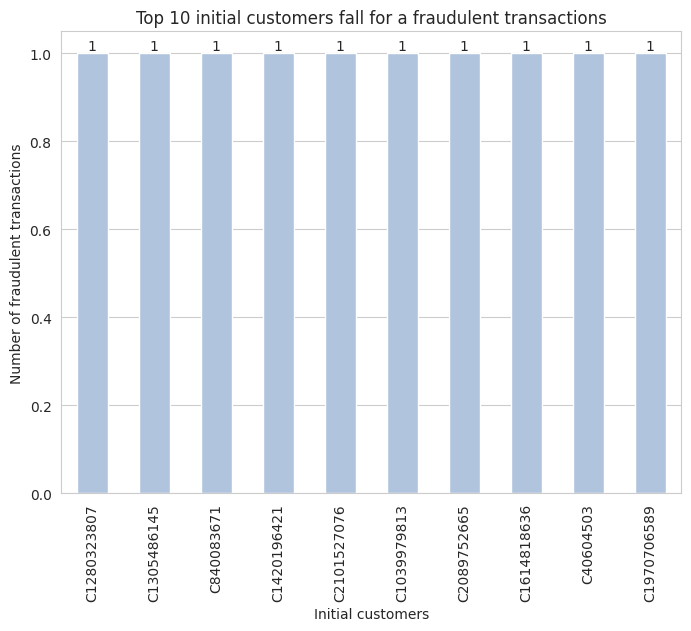

In [ ]:
df2 = df1['nameOrig'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 initial customers fall for a fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Initial customers')
plt.grid(axis='x')

del ax, df2

* Initial customers are scammed of **at most one** for a fraudulent transaction.

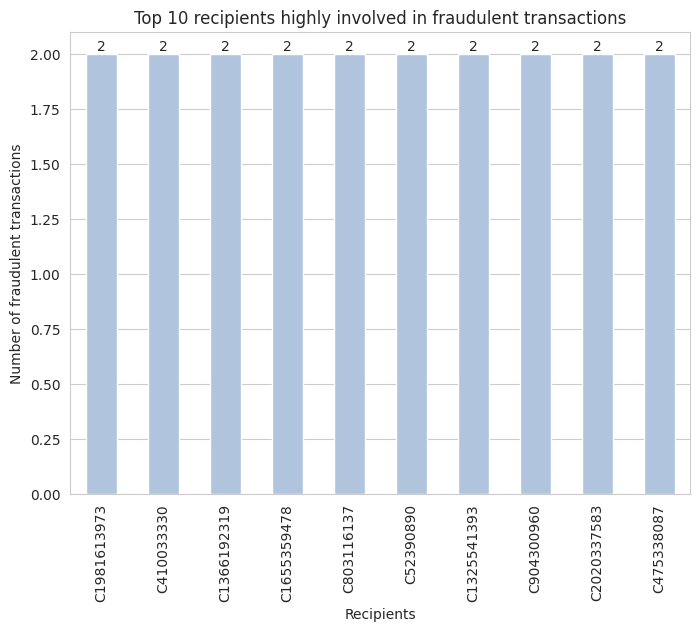

In [ ]:
df2 = df1['nameDest'].value_counts().head(10)
ax = df2.plot(kind='bar', color='lightsteelblue')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 recipients highly involved in fraudulent transactions')
plt.ylabel('Number of fraudulent transactions')
plt.xlabel('Recipients')
plt.grid(axis='x')

del ax, df2

* Suspicious recipients only have a **maximum of 2** involved fraudulent transactions.

Text(0.5, 0, 'Recipient pre-transaction balance amount')

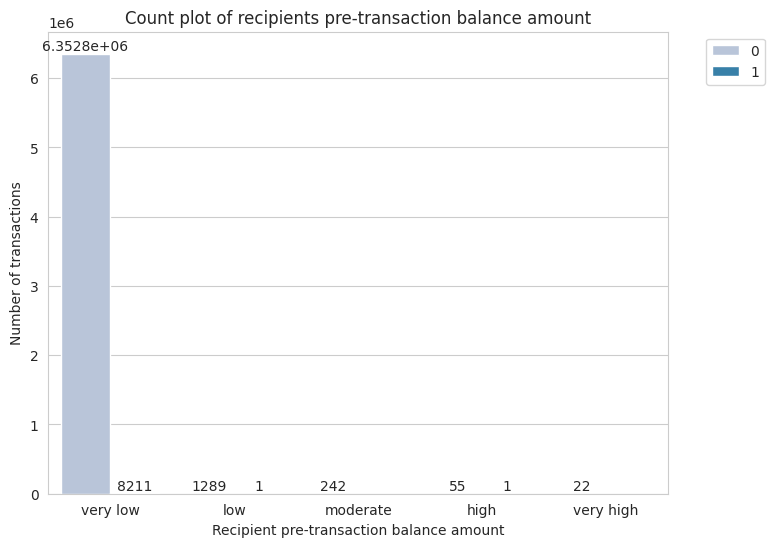

In [ ]:
df['oldbalanceDest_amt'] = pd.cut(df['oldbalanceDest'], 5, labels=['very low', 'low', 'moderate', 'high', 'very high'])

ax = sns.countplot(x='oldbalanceDest_amt', data=df, hue='isFraud', palette='PuBu')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Count plot of recipients pre-transaction balance amount')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions')
plt.xlabel('Recipient pre-transaction balance amount')

* Recipients with **very low pre-transaction balances** has the highest number of fraudulent transactions.
* This implies that recipients with very low pre-transaction balances may be more susceptible to fraudulent transactions.

<h2>
    <div style='background:steelblue'>
    <font color='white'>
    <b>&nbsp; Multivariate data visualization</b>
    </font>
    </div>
</h2>

Text(0.5, 1.0, 'Correlation')

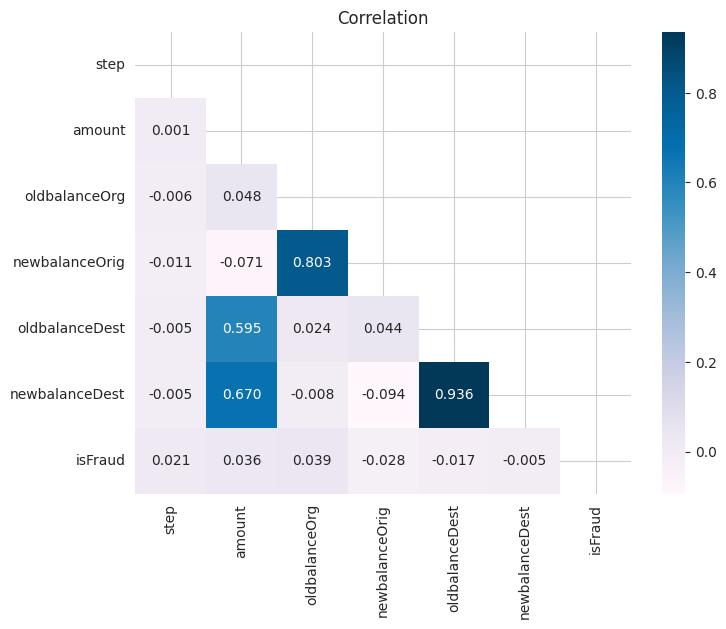

In [ ]:
# Select only the numerical features for correlation analysis
numerical_features = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = numerical_features.corr('spearman')

# Plot the heatmap
sns.heatmap(corr_matrix, cbar=True, annot=True, mask=np.triu(np.ones_like(corr_matrix, dtype=bool)), fmt='.3f', cmap='PuBu')
plt.title('Correlation')

* oldbalanceOrg and newbalanceOrig has **strong positive** relationship.
* oldbalanceDest and newbalanceDest has **strong positive** relationship.
* oldbalanceOrg and amount has **weak positive** relationship.
* newbalanceOrig and amount has **moderate positive** relationship.

# <div style='background:darkblue'> <font color='white'> <b>&nbsp; Model Building</b> </font> </div>

In [ ]:
# Data preprocessing
df['type'] = df['type'].map({'PAYMENT':0, 'CASH_IN':1, 'DEBIT':2, 'CASH_OUT':3, 'TRANSFER':4})

Due to the large dataset, Random Forest and Logistic Regression with balanced class weight are used to identify online payment fraud.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_curve, auc, ConfusionMatrixDisplay


seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


X = df.copy()
X.drop(['nameOrig', 'newbalanceOrig', 'nameDest', 'newbalanceDest', 'amount', 'oldbalanceOrg_amt', 'oldbalanceDest_amt', 'quantity'], axis=1, inplace=True)
y = X.pop('isFraud')


# Stratified train-test split
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for train_idx, test_idx in skfold.split(X,y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


sc = StandardScaler()
scaled_train = sc.fit_transform(X_train)
scaled_test = sc.transform(X_test)
X_train = pd.DataFrame(scaled_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaled_test, index=X_test.index, columns=X_test.columns)


X_train, y_train = RandomUnderSampler(sampling_strategy='majority').fit_resample(X_train, y_train)

In [ ]:
def model_comparison_evaluate(classifiers, X, y):
    print('K-Fold Cross-Validation:\n')
    for name, model in classifiers.items():
        print('{}:'.format(name))

        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

        for score in scoring:
            # Impute NaN values using the mean of each column
            # This is done within each cross-validation fold to avoid data leakage
            from sklearn.impute import SimpleImputer
            imputer = SimpleImputer(strategy='mean')

            scores = cross_val_score(model, imputer.fit_transform(X), y, scoring=score, cv=skfold, n_jobs=-1)
            print('Mean {} score: {:.3f} ({:.3f})'.format(score, scores.mean(), scores.std()))

        print('\n')

In [ ]:
classifiers = { 'Random Forest Classifier':RandomForestClassifier(class_weight='balanced', random_state=seed),
                'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=seed)
              }

In [ ]:
model_comparison_evaluate(classifiers, X_train, y_train)

K-Fold Cross-Validation:

Random Forest Classifier:
Mean accuracy score: 0.940 (0.004)
Mean precision score: 0.937 (0.005)
Mean recall score: 0.944 (0.003)
Mean f1 score: 0.941 (0.004)
Mean roc_auc score: 0.986 (0.002)


Logistic Regression:
Mean accuracy score: 0.820 (0.008)
Mean precision score: 0.810 (0.010)
Mean recall score: 0.837 (0.007)
Mean f1 score: 0.823 (0.008)
Mean roc_auc score: 0.913 (0.005)




Random Forest Classifier:
               precision    recall  f1-score   support

Non-Fraud [0]       0.94      1.00      0.97   1192545
    Fraud [1]       0.95      0.02      0.04     79979

     accuracy                           0.94   1272524
    macro avg       0.94      0.51      0.50   1272524
 weighted avg       0.94      0.94      0.91   1272524
 



Text(0.5, 0, 'False Positive Rate')

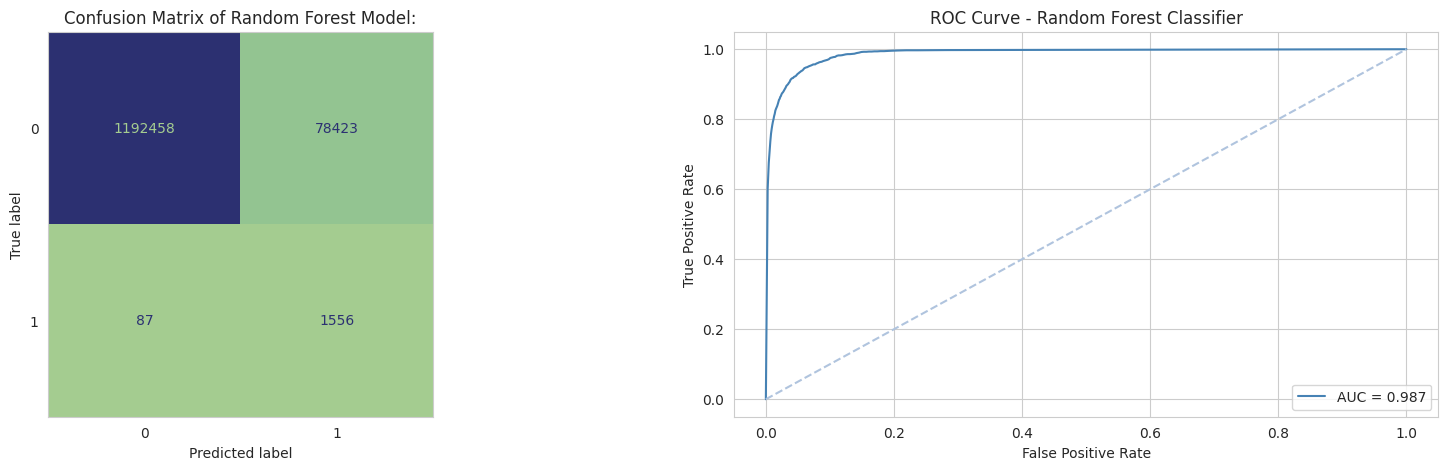

In [ ]:
model = RandomForestClassifier(class_weight='balanced', random_state=seed)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_score = model.predict_proba(X_test)[:,1]
print('Random Forest Classifier:')
print(classification_report(y_pred, y_test, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']), '\n')

fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('Confusion Matrix of Random Forest Model:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, values_format='', cmap='crest', ax=ax[0])
ax[0].grid(False)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)
roc_auc = auc(fpr, tpr)
ax[1].set_title('ROC Curve - Random Forest Classifier')
ax[1].plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc, c='steelblue')
ax[1].plot([0,1],[0,1],'--', c='lightsteelblue')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

In [ ]:
from sklearn.tree import DecisionTreeClassifier

classifiers = {
    'Random Forest Classifier': RandomForestClassifier(class_weight='balanced', random_state=seed),
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=seed),
    'Decision Tree Classifier': DecisionTreeClassifier(class_weight='balanced', random_state=seed)
}

model_comparison_evaluate(classifiers, X_train, y_train)

K-Fold Cross-Validation:

Random Forest Classifier:
Mean accuracy score: 0.940 (0.004)
Mean precision score: 0.937 (0.005)
Mean recall score: 0.944 (0.003)
Mean f1 score: 0.941 (0.004)
Mean roc_auc score: 0.986 (0.002)


Logistic Regression:
Mean accuracy score: 0.820 (0.008)
Mean precision score: 0.810 (0.010)
Mean recall score: 0.837 (0.007)
Mean f1 score: 0.823 (0.008)
Mean roc_auc score: 0.913 (0.005)


Decision Tree Classifier:
Mean accuracy score: 0.923 (0.005)
Mean precision score: 0.924 (0.006)
Mean recall score: 0.923 (0.005)
Mean f1 score: 0.923 (0.005)
Mean roc_auc score: 0.923 (0.005)




In [ ]:
# Train and evaluate the Decision Tree model
model = DecisionTreeClassifier(class_weight='balanced', random_state=seed)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_score = model.predict_proba(X_test)[:, 1]

print('Decision Tree Classifier:')
print(classification_report(y_pred, y_test, labels=[0, 1], target_names=['Non-Fraud [0]', 'Fraud [1]']), '\n')

Decision Tree Classifier:
               precision    recall  f1-score   support

Non-Fraud [0]       0.93      1.00      0.96   1178688
    Fraud [1]       0.92      0.02      0.03     93836

     accuracy                           0.93   1272524
    macro avg       0.92      0.51      0.50   1272524
 weighted avg       0.93      0.93      0.89   1272524
 



Text(0.5, 0, 'False Positive Rate')

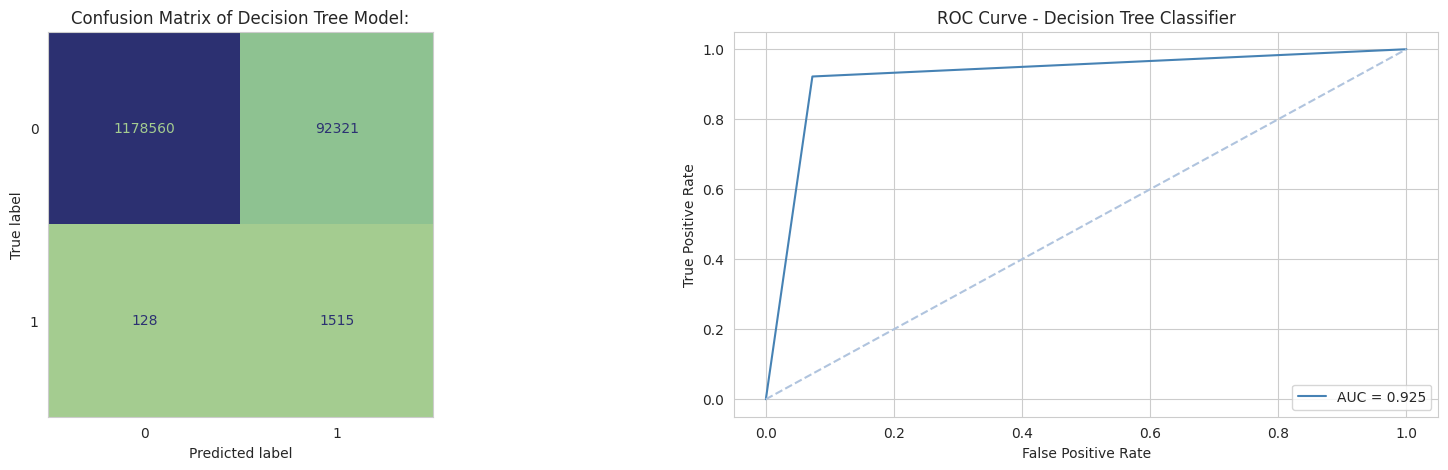

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title('Confusion Matrix of Decision Tree Model:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, values_format='', cmap='crest', ax=ax[0])
ax[0].grid(False)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)
roc_auc = auc(fpr, tpr)
ax[1].set_title('ROC Curve - Decision Tree Classifier')
ax[1].plot(fpr, tpr, label='AUC = %0.3f' % roc_auc, c='steelblue')
ax[1].plot([0, 1], [0, 1], '--', c='lightsteelblue')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

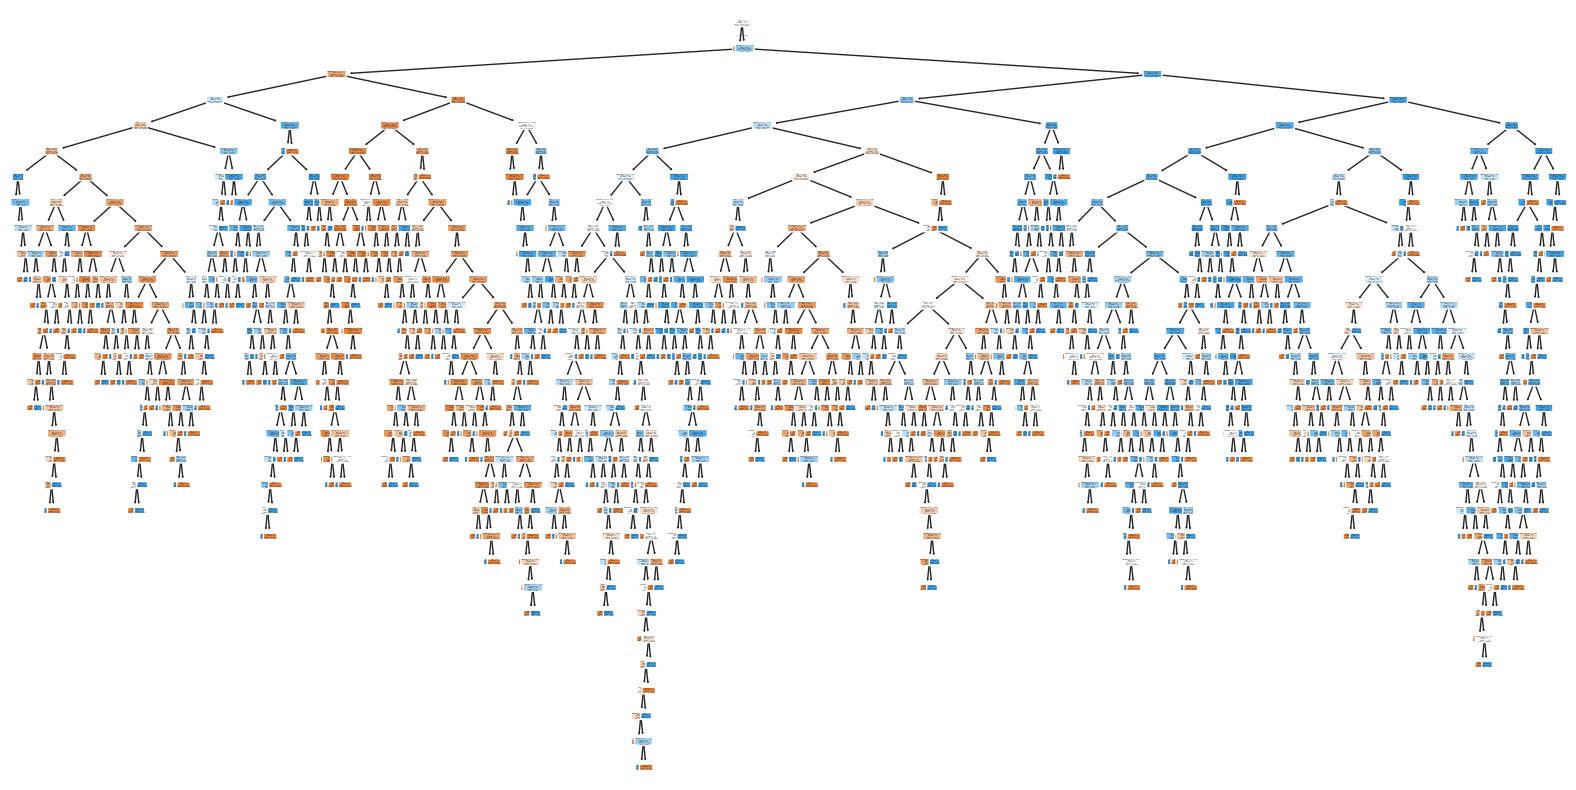

In [ ]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=X_train.columns, class_names=['Non-Fraud', 'Fraud'], rounded=True)
plt.show()

In [ ]:
from sklearn.impute import SimpleImputer

# Create an imputer to replace NaN with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on your training data and transform both train and test data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Now you can train your model using the imputed data
model = LogisticRegression(class_weight='balanced', random_state=seed)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_score = model.predict_proba(X_test)[:,1]
print('Logistic Regression:')
print(classification_report(y_pred, y_test, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']), '\n')

Logistic Regression:
               precision    recall  f1-score   support

Non-Fraud [0]       0.80      1.00      0.89   1013688
    Fraud [1]       0.84      0.01      0.01    258836

     accuracy                           0.80   1272524
    macro avg       0.82      0.50      0.45   1272524
 weighted avg       0.81      0.80      0.71   1272524
 



Text(0.5, 0, 'False Positive Rate')

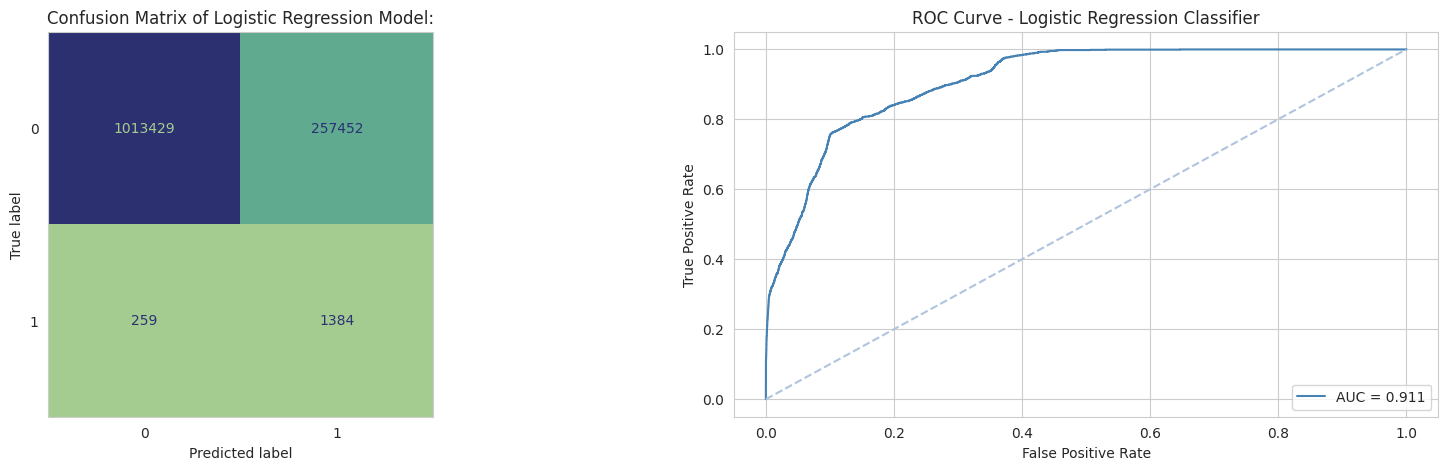

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('Confusion Matrix of Logistic Regression Model:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, colorbar=False, values_format='', cmap='crest', ax=ax[0])
ax[0].grid(False)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)
roc_auc = auc(fpr, tpr)
ax[1].set_title('ROC Curve - Logistic Regression Classifier')
ax[1].plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc, c='steelblue')
ax[1].plot([0,1],[0,1],'--', c='lightsteelblue')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

In [ ]:
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

# Initialize the imputer to replace NaN with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on your training data and transform both train and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize the SVM classifier
svm_model = SVC(kernel='linear', C=1, probability=True, random_state=seed)

# Train the SVM model using the imputed data
svm_model.fit(X_train_imputed, y_train)

# Make predictions on the test set using the imputed data
y_pred_svm = svm_model.predict(X_test_imputed)
y_pred_score_svm = svm_model.predict_proba(X_test_imputed)[:, 1]

# Evaluate the SVM model
print('Support Vector Machine:')
print(classification_report(y_pred_svm, y_test, labels=[0, 1], target_names=['Non-Fraud [0]', 'Fraud [1]']), '\n')

Support Vector Machine:
               precision    recall  f1-score   support

Non-Fraud [0]       0.82      1.00      0.90   1037959
    Fraud [1]       0.82      0.01      0.01    234565

     accuracy                           0.82   1272524
    macro avg       0.82      0.50      0.46   1272524
 weighted avg       0.82      0.82      0.74   1272524
 



Text(0.5, 0, 'False Positive Rate')

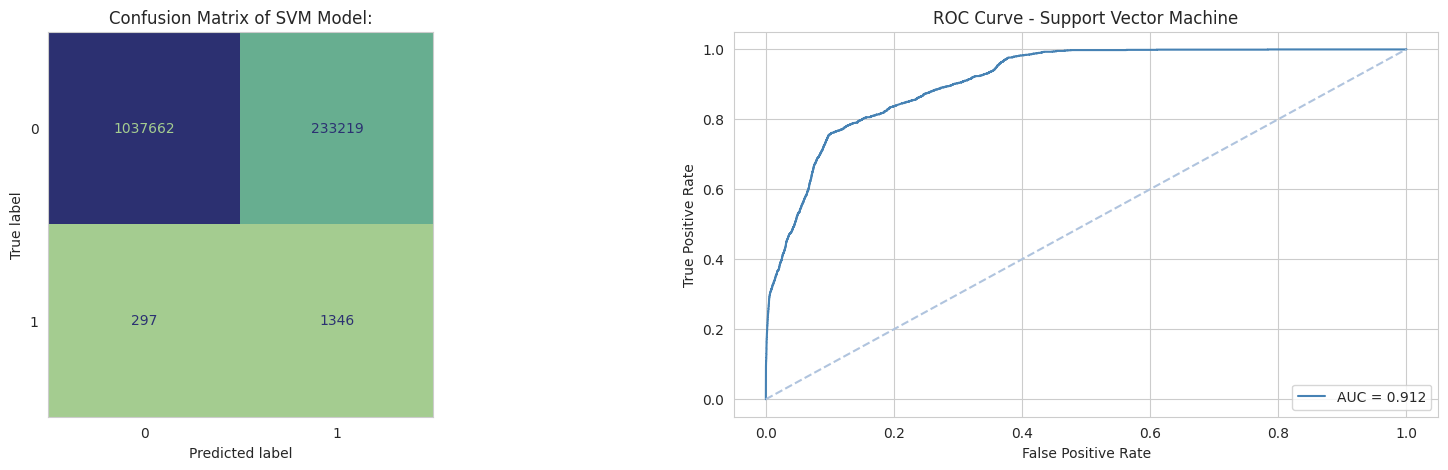

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('Confusion Matrix of SVM Model:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, colorbar=False, values_format='', cmap='crest', ax=ax[0])
ax[0].grid(False)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score_svm)
roc_auc = auc(fpr, tpr)
ax[1].set_title('ROC Curve - Support Vector Machine')
ax[1].plot(fpr, tpr, label = 'AUC = %0.3f' % roc_auc, c='steelblue')
ax[1].plot([0,1],[0,1],'--', c='lightsteelblue')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, auc, ConfusionMatrixDisplay

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_score_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the XGBoost model
print('XGBoost Classifier:')
print(classification_report(y_pred_xgb, y_test, labels=[0, 1], target_names=['Non-Fraud [0]', 'Fraud [1]']), '\n')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:16:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier:
               precision    recall  f1-score   support

Non-Fraud [0]       0.95      1.00      0.97   1204335
    Fraud [1]       0.95      0.02      0.04     68189

     accuracy                           0.95   1272524
    macro avg       0.95      0.51      0.51   1272524
 weighted avg       0.95      0.95      0.92   1272524
 



Text(0.5, 0, 'False Positive Rate')

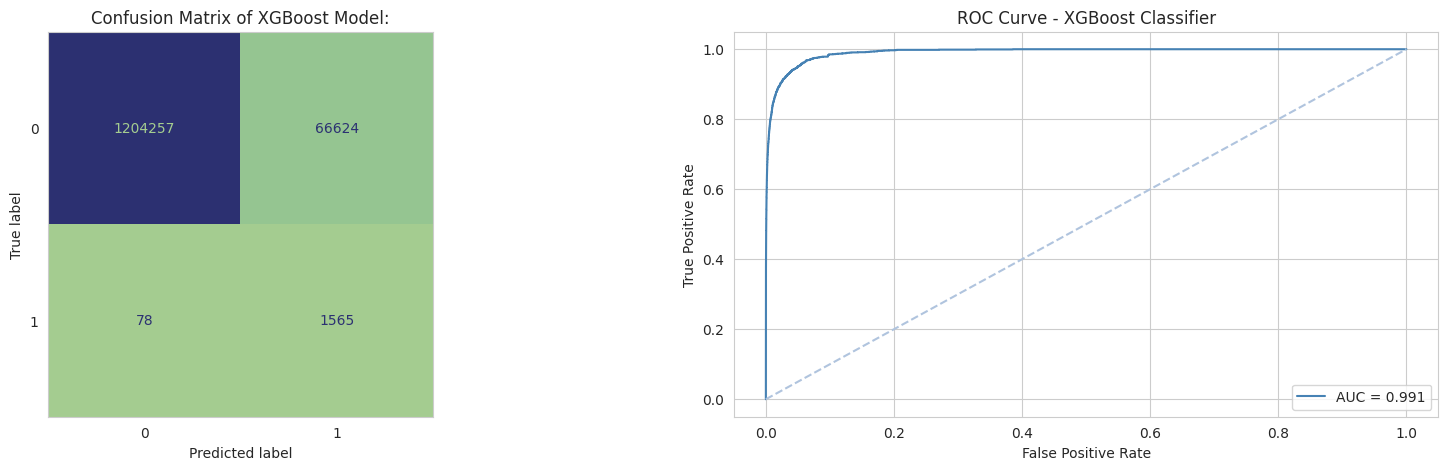

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title('Confusion Matrix of XGBoost Model:')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, colorbar=False, values_format='', cmap='crest', ax=ax[0])
ax[0].grid(False)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score_xgb)
roc_auc = auc(fpr, tpr)
ax[1].set_title('ROC Curve - XGBoost Classifier')
ax[1].plot(fpr, tpr, label='AUC = %0.3f' % roc_auc, c='steelblue')
ax[1].plot([0, 1], [0, 1], '--', c='lightsteelblue')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

* From the confusion matrix, 1,239,155 were correctly classified as non-fraudulent payments, and 31,726 people were misclassified as non-fraudulent payments.
* According to the confusion matrix, 1,639 payments were incorrectly labelled as fraud while 4 payments were correctly identified as fraud.

# **Advanced EDA**

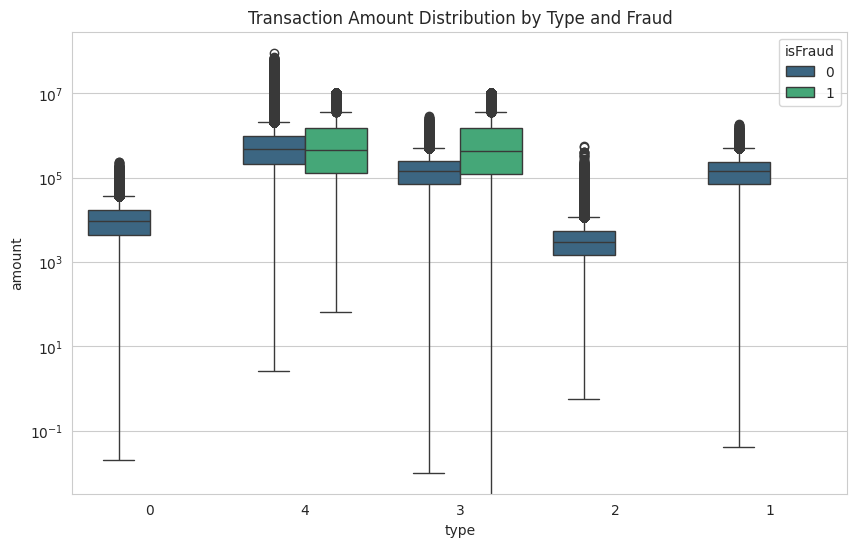

In [ ]:
# Amount vs. Transaction Type and Fraud
plt.figure(figsize=(10, 6))
# Before plotting, convert 'type' to numeric or string
df['type'] = df['type'].astype(str)

sns.boxplot(x='type', y='amount', hue='isFraud', data=df, palette='viridis')
plt.title('Transaction Amount Distribution by Type and Fraud')
plt.yscale('log')  # Use log scale for better visualization of large amounts
plt.show()

<Figure size 1200x600 with 0 Axes>

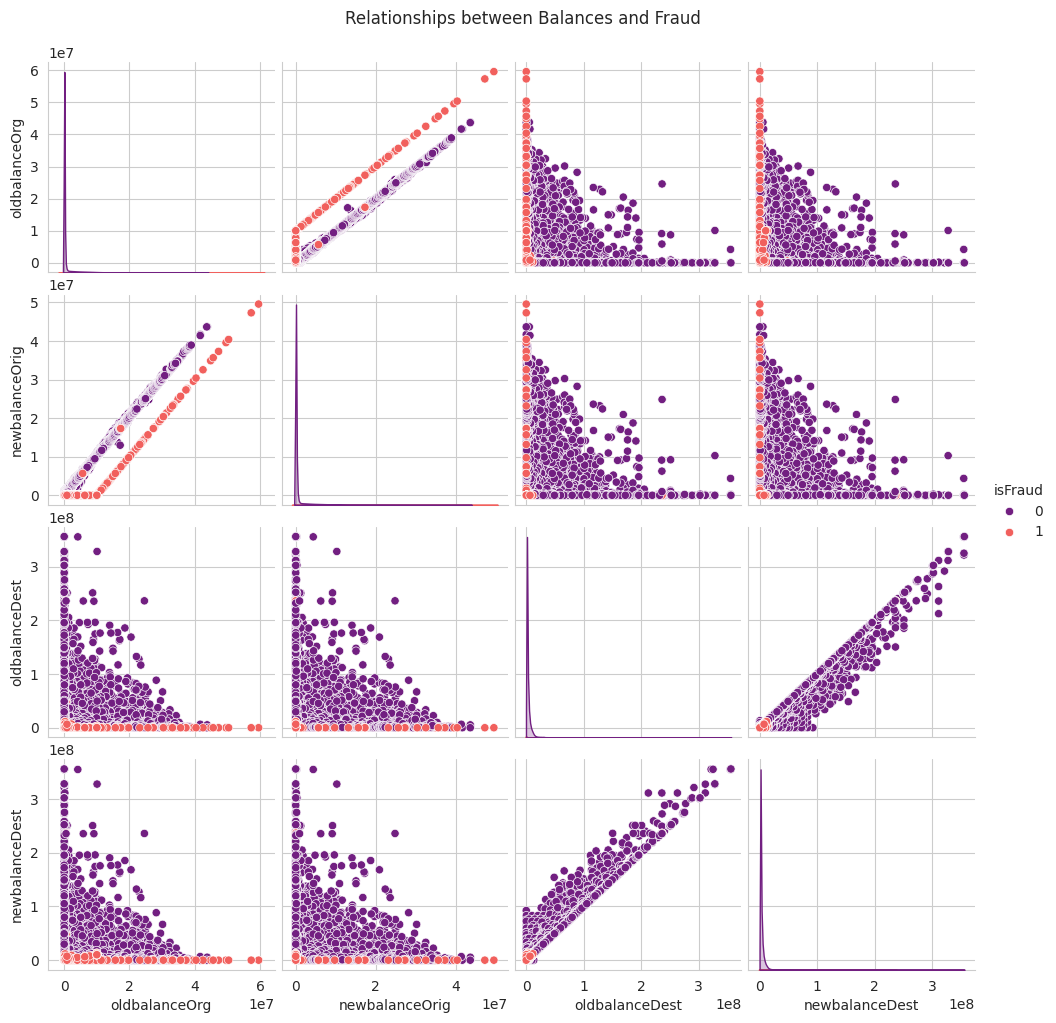

In [ ]:
# Balance Changes and Fraud
plt.figure(figsize=(12, 6))
sns.pairplot(data=df, vars=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], hue='isFraud', palette='magma', diag_kind='kde')
plt.suptitle('Relationships between Balances and Fraud', y=1.02)
plt.show()

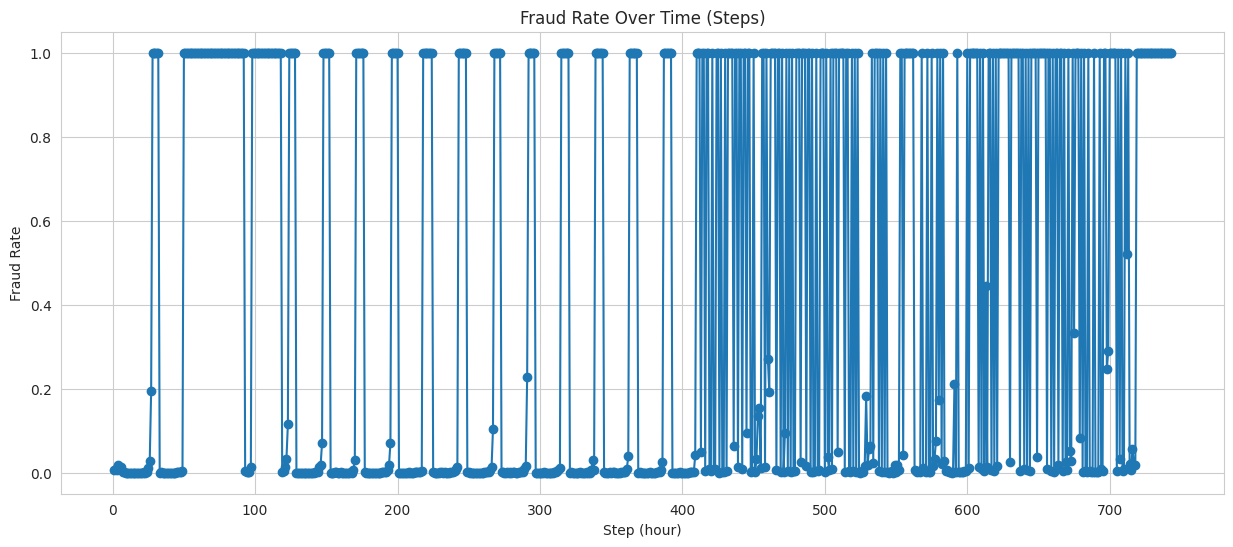

In [ ]:
# Step vs. Fraud (more detailed)
plt.figure(figsize=(15, 6))
df.groupby('step')['isFraud'].mean().plot(kind='line', marker='o')
plt.title('Fraud Rate Over Time (Steps)')
plt.xlabel('Step (hour)')
plt.ylabel('Fraud Rate')
plt.show()

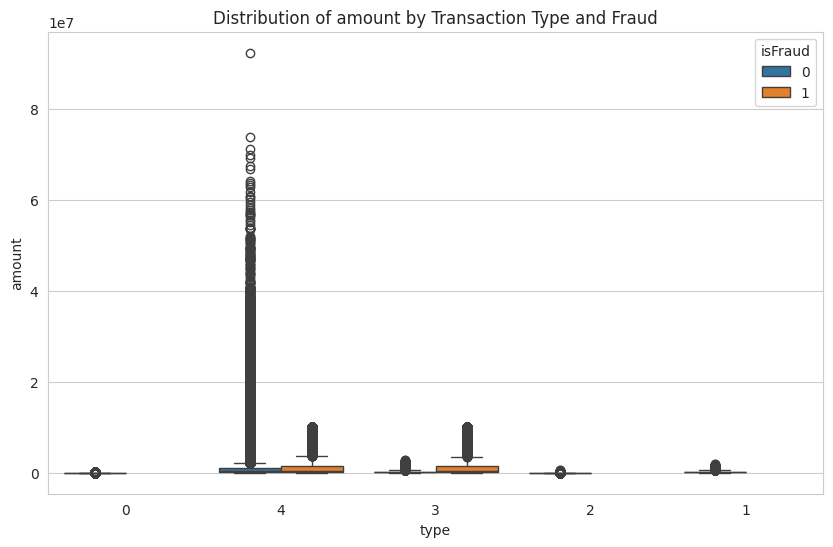

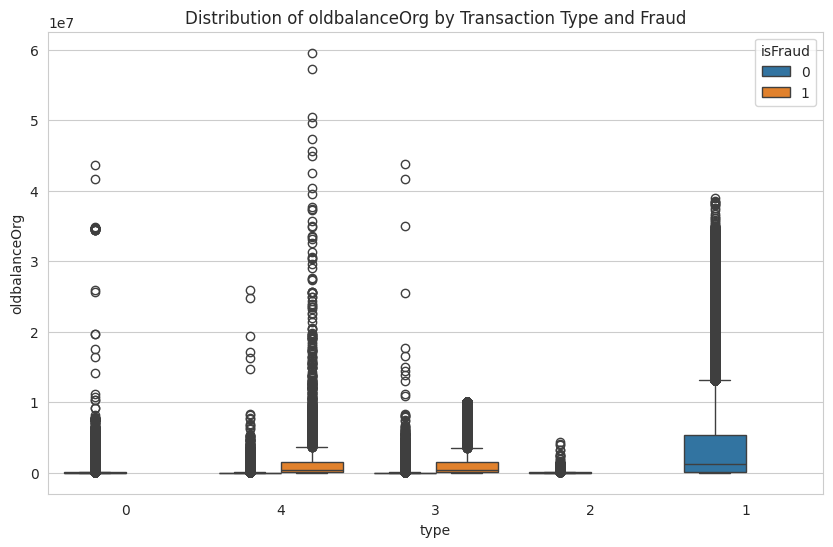

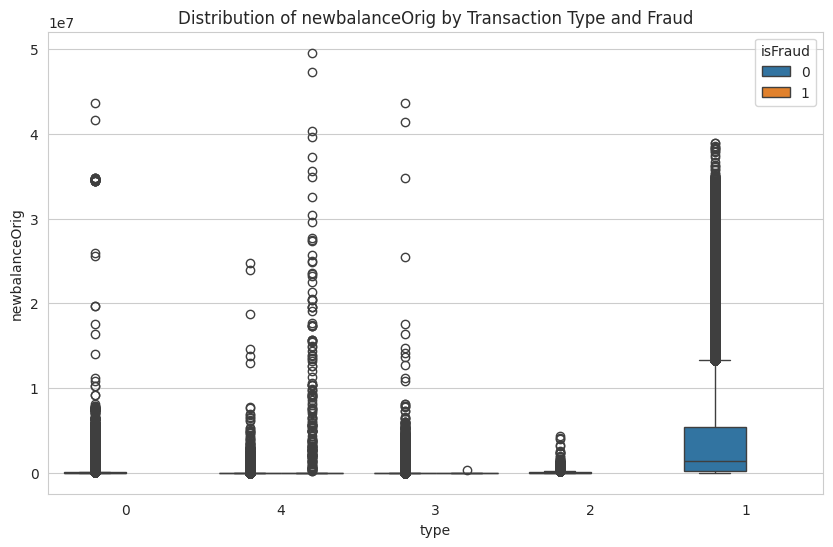

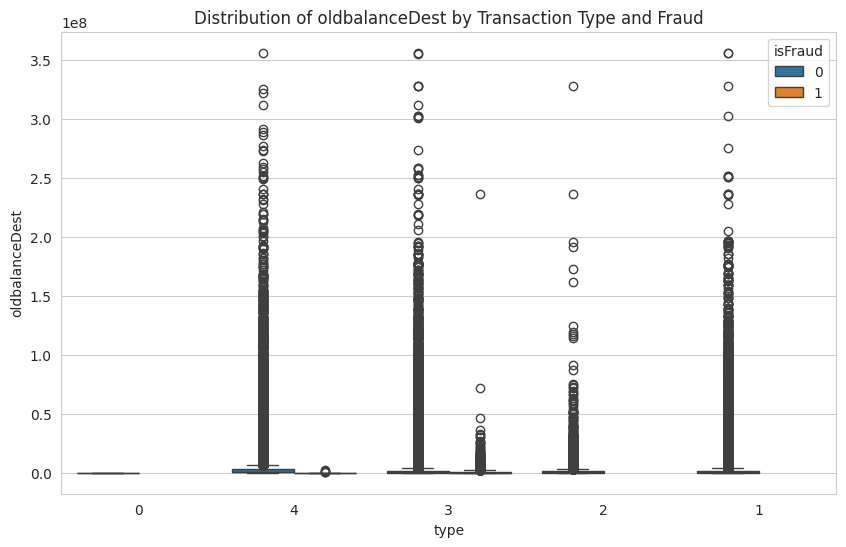

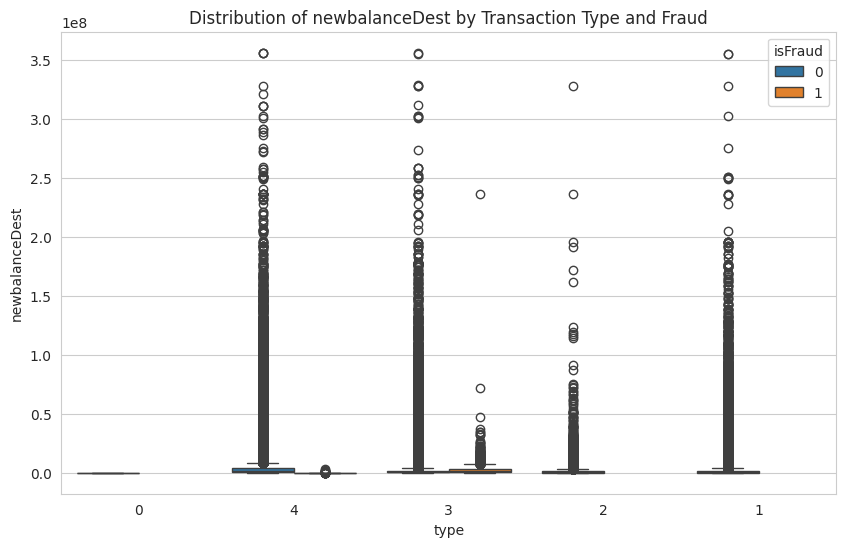

In [ ]:
# Explore interactions between 'type' and other numerical features
for col in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='type', y=col, hue='isFraud', data=df)
    plt.title(f'Distribution of {col} by Transaction Type and Fraud')
    plt.show()

In [ ]:
# What is the average transaction amount for fraudulent and non-fraudulent transactions?
print("Average transaction amounts:")
print(df.groupby('isFraud')['amount'].mean())

Average transaction amounts:
isFraud
0    1.781970e+05
1    1.467967e+06
Name: amount, dtype: float64


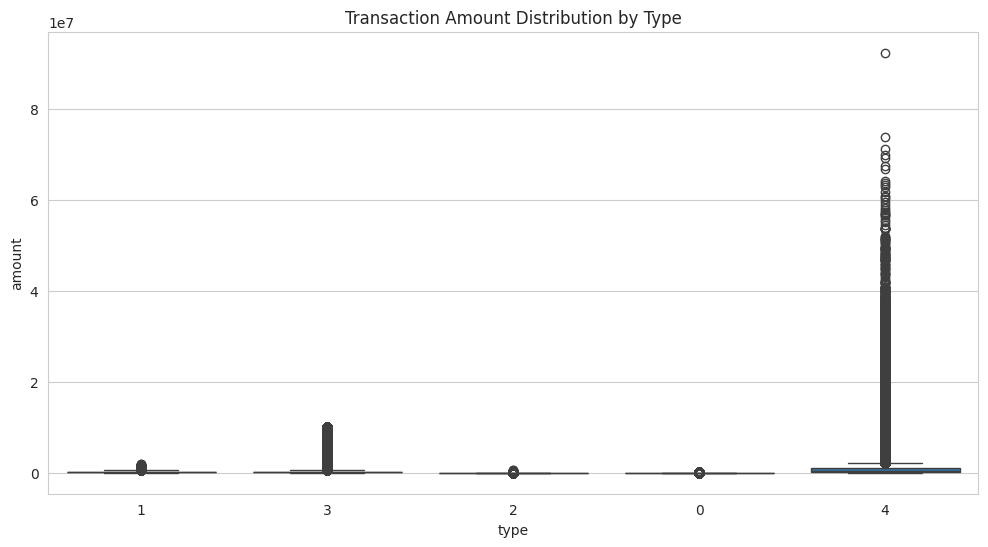

In [ ]:
# How does the transaction amount distribution differ between transaction types?
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='amount', data=df)
plt.title('Transaction Amount Distribution by Type')
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


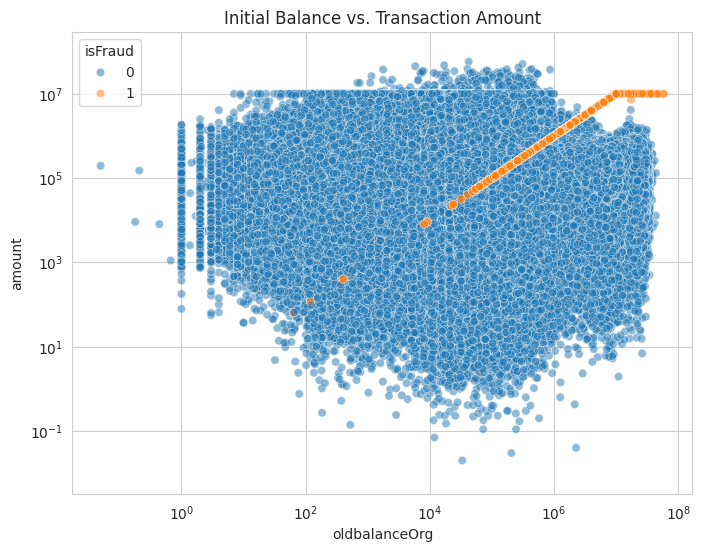

In [ ]:
# What is the relationship between the initial customer balance and the transaction amount?
plt.figure(figsize=(8, 6))
sns.scatterplot(x='oldbalanceOrg', y='amount', hue='isFraud', data=df, alpha=0.5)
plt.title('Initial Balance vs. Transaction Amount')
plt.xscale('log')  # Use log scale for better visualization
plt.yscale('log')
plt.show()

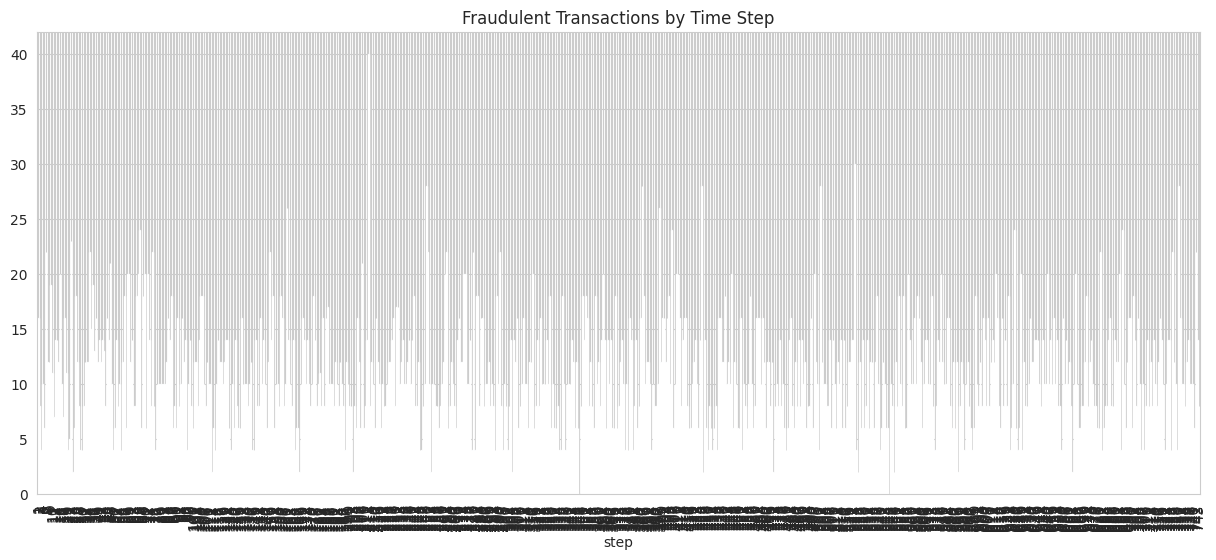

In [ ]:
# Are there specific time periods (steps) with a higher frequency of fraudulent transactions?
plt.figure(figsize=(15, 6))
df.groupby('step')['isFraud'].sum().plot(kind='bar')  # Plot the sum of fraudulent transactions per step
plt.title('Fraudulent Transactions by Time Step')
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


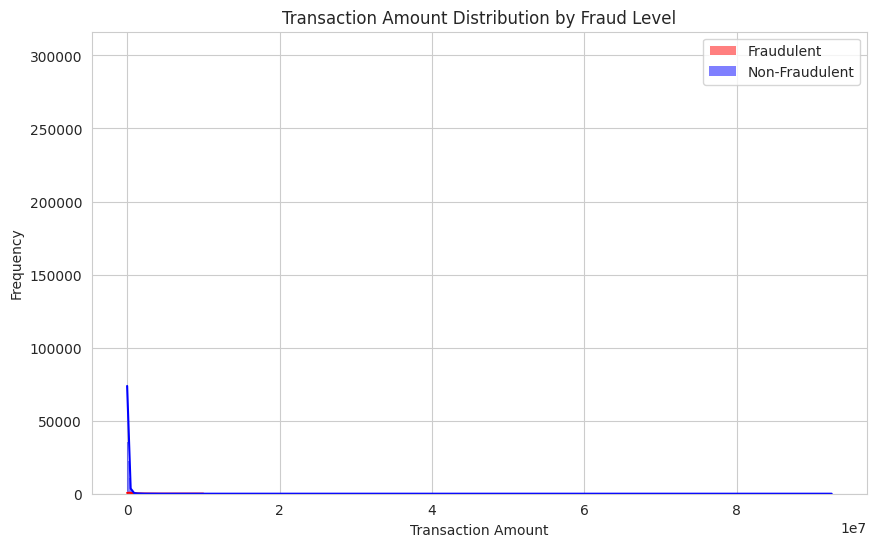

In [ ]:
# What is the distribution of transaction amounts for different fraud levels?
plt.figure(figsize=(10, 6))
sns.histplot(df[df['isFraud'] == 1]['amount'], label='Fraudulent', kde=True, color='red', alpha=0.5)
sns.histplot(df[df['isFraud'] == 0]['amount'], label='Non-Fraudulent', kde=True, color='blue', alpha=0.5)

plt.title('Transaction Amount Distribution by Fraud Level')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

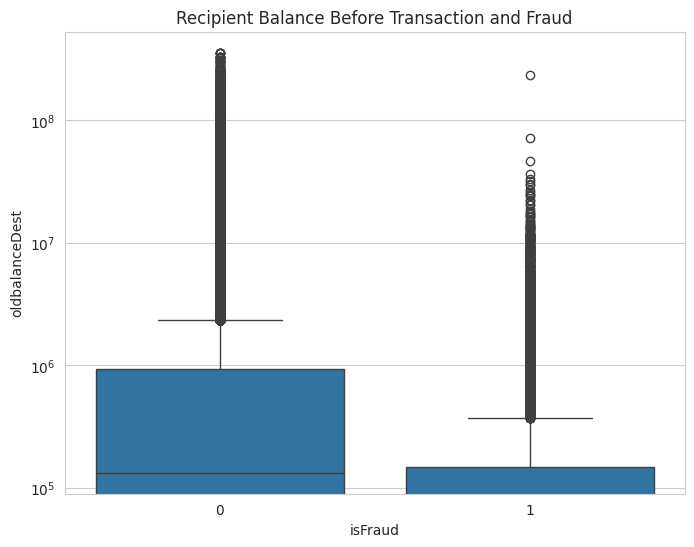

In [ ]:
# How does the recipient's balance before the transaction relate to fraud?
plt.figure(figsize=(8, 6))
sns.boxplot(x='isFraud', y='oldbalanceDest', data=df)
plt.title('Recipient Balance Before Transaction and Fraud')
plt.yscale('log')
plt.show()

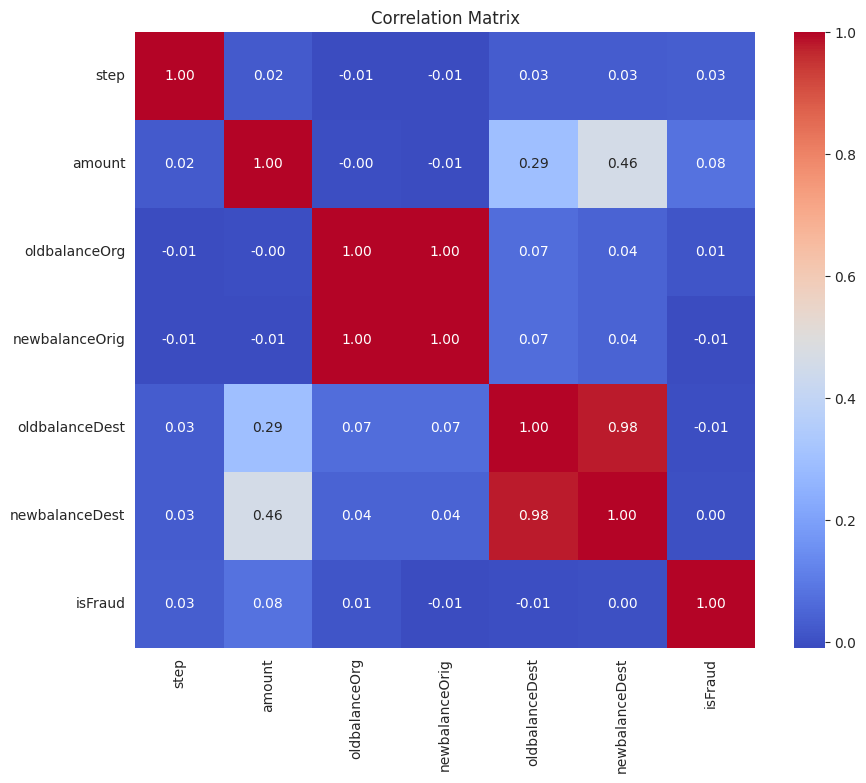

In [ ]:
# Analyze the correlation between different numerical features, especially in relation to fraud.
correlation_matrix = df.select_dtypes(include=['number']).corr() # Select only numeric columns for correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

<ipython-input-54-ef271ee09bd3>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rates = df.groupby('type')['isFraud'].mean()


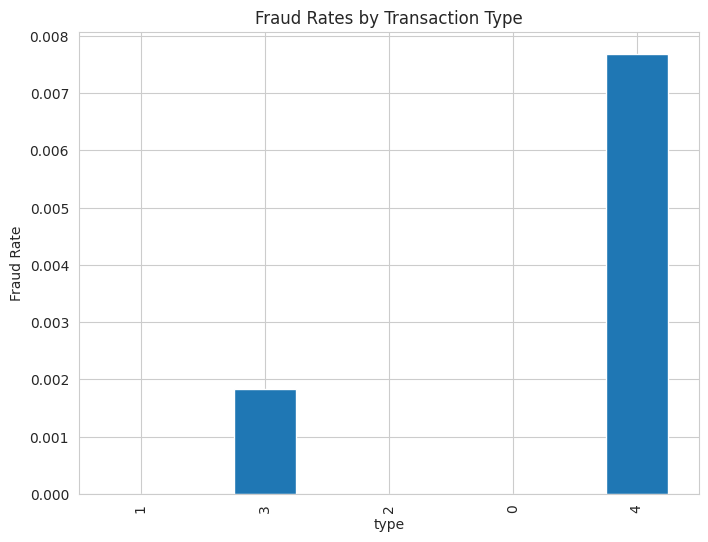

In [ ]:
# Which transaction types have the highest fraud rates?
fraud_rates = df.groupby('type')['isFraud'].mean()
plt.figure(figsize=(8, 6))
fraud_rates.plot(kind='bar')
plt.title('Fraud Rates by Transaction Type')
plt.ylabel('Fraud Rate')
plt.show()

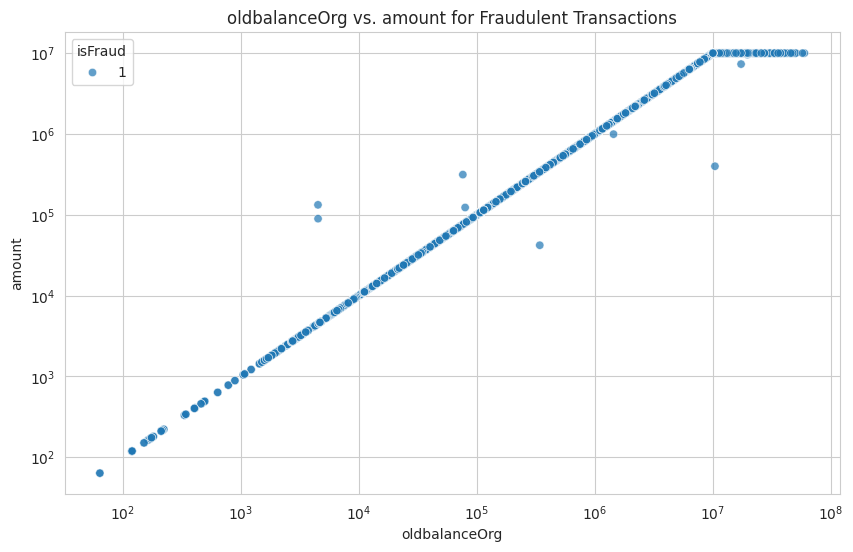

In [ ]:
# Investigate the relationship between transaction amount and the oldbalanceOrg for fraudulent transactions.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='oldbalanceOrg', y='amount', hue='isFraud', data=df[df['isFraud'] == 1], alpha=0.7)
plt.title('oldbalanceOrg vs. amount for Fraudulent Transactions')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
# Are there specific destination accounts ('nameDest') associated with a higher number of fraudulent transactions?
top_fraudulent_destinations = df[df['isFraud'] == 1]['nameDest'].value_counts().head(10)
print("\nTop 10 Destination Accounts with Fraudulent Transactions:")
top_fraudulent_destinations


Top 10 Destination Accounts with Fraudulent Transactions:


,count
nameDest,
C1981613973,2
C410033330,2
C1366192319,2
C1655359478,2
C803116137,2
C52390890,2
C1325541393,2
C904300960,2
C2020337583,2


# <div style='background:darkblue'>  <font color='white'> <b>&nbsp; Conclusion</b> </font> </div>

* Random Forest obtains the highest score of all using K-fold cross-validation.
* The best performing model is **Random Forest** for identifying fraudulent and non-fraudulent payments, as the AUC is 0.999, which is close to 1. This means it has a good separability measure, and the model has an 99.9% chance of being able to distinguish between positive and negative classes..